# Dogs vs Cats
In this section, we'll start by naively training a small convnet on the 2000 training samples, without any regularization, to set a base-line for what can be achieved. This will get us to a classification accuracy of 71%. At that point, the main issue will be overfitting. Then we'll introduce *data augmentation* , a powerful technique for mitigating overfitting in computer vision. By using data augmentation, we'll improve the network to reach an accuracy of 82%.

In next section, we'll review two more essential techniques for applying deep learning to small datasets: *feature extraction with a pretrained network* (which will get an accuracy of 90% to 96%) and *fine-tuning a pretrained network* (97%). Together, there three strategies will constitute our future toolbox for tackling the problem of performing image classification with small datasets.

__The following code does not run twice__

Making small dataset folder

In [64]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("/home/ubuntu/dlp_fc/chpt5/data/kaggle_original_data/train/train")
new_base_dir = pathlib.Path("/home/ubuntu/dlp_fc/chpt5/data/cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

This is a balanced __binary-classification__ problem, which means classification accuracy will be an appropriate measure of success.

The depth of the feature maps progressively increases in the network (from 32 to 128), whereas the size of the feature maps decreases (from $148^2$ to $7^2$). This's a pattern you'll see in almost all convnets.

In [66]:
from tensorflow import keras
from tensorflow.keras import layers

#define input shape
inputs = keras.Input(shape=(180, 180, 3))

# define layers
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

# define last layer and its activation function
outputs = layers.Dense(1, activation="sigmoid")(x)

# generate model
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Configuring the model for training

In [68]:
model.compile(optimizer='rmsprop',
              loss="binary_crossentropy",
              metrics=["accuracy"])

### Data preprocessing

Data should be formatted into appropriately preprocessed floating-point tensors before being fed into the network. The steps for getting data into the network are roughly as follows:
1. Read the pic files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Rescale the pixels values (between 0 and 255) to the [0, 1] interval.

In [69]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "train"),
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "validation"),
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "test"),
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [70]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Fitting the model using a batch generator

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset)

In [72]:
model.save('cats_vs_dogs_small_1.h5')

<Figure size 432x288 with 0 Axes>

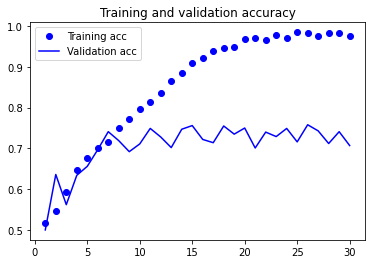

<Figure size 432x288 with 0 Axes>

In [73]:
import matplotlib.pyplot as plt

# history.history.keys(): ['loss', 'accuracy', 'val_loss', 'val_accuracy']
result = history.history
acc = result['accuracy']
val_acc = result['val_accuracy']
loss = result['loss']
val_loss = result['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

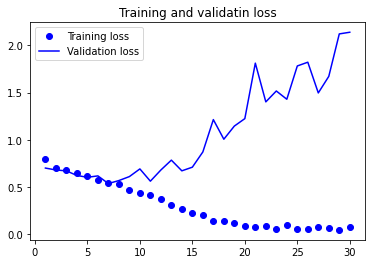

In [74]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validatin loss')
plt.legend()

plt.show()

In [75]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 49ms/step - loss: 0.6115 - accuracy: 0.7190
Test accuracy: 0.719


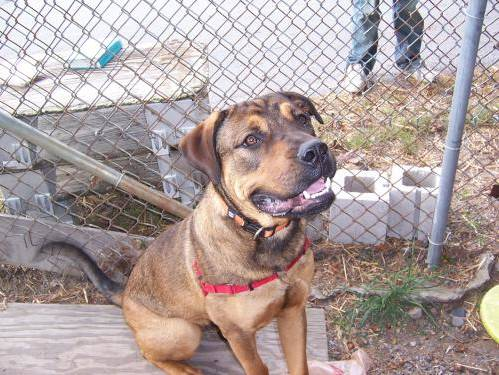

In [76]:
from IPython.display import Image

test_img_path = './data/cats_vs_dogs_small/test'
Image(filename = os.path.join(test_img_path, "dog/dog.2499.jpg"))

Used for generating classes list

In [77]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_dir = "/home/ubuntu/dlp_fc/chpt5/data/cats_vs_dogs_small/train"
generator = train_datagen.flow_from_directory(train_dir,
                                              batch_size = 32,
                                              target_size = (180, 180),
                                              class_mode = 'binary')

Found 2000 images belonging to 2 classes.


Let's get started to predict

In [78]:
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# load the model we saved
model = load_model('cats_vs_dogs_small_1.h5')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# predicting images
img = image.load_img(os.path.join(test_img_path, "dog/dog.2499.jpg"), target_size=(180, 180))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.array(x)
prediction = model.predict(images, batch_size=32)
print(prediction)

label_map = generator.class_indices
label_map
# A dog but not that firmly

[[0.86968774]]


{'cat': 0, 'dog': 1}

Eventually, we can confirm it is a dog using basline model
## Data augmentation
Data augmentation takes the approach of generating more training data from existing training samples, by *augmenting* the samples via a number of random transformations that yield believable-looking images. The goal is that at running time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In [34]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ])

Display some random augmentation images

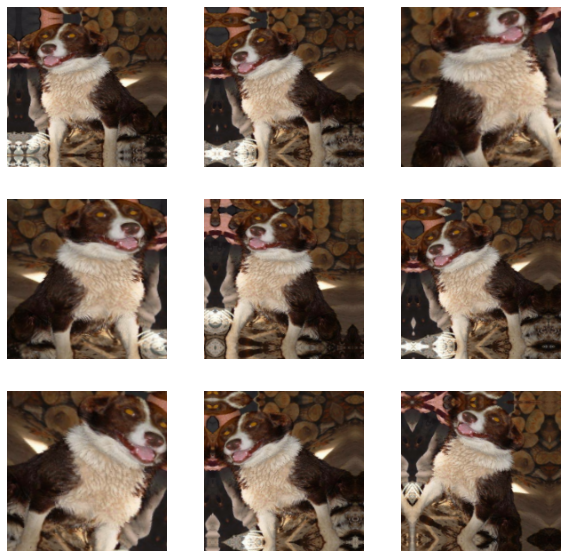

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Looks awesome!

Define a new convnet model that include __image augmentation__ and __dropout__. To further fight overfitting, you'll also add a Dropout layer to your model, right before the densely connected classifier.

In [36]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [38]:
model.save('cats_and_dogs_augmentation.h5')

<Figure size 432x288 with 0 Axes>

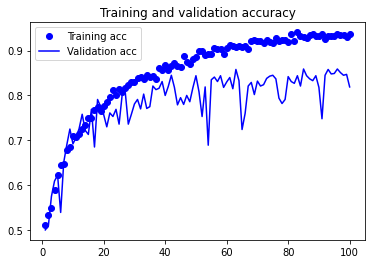

<Figure size 432x288 with 0 Axes>

In [39]:
result = history.history
acc = result['accuracy']
val_acc = result['val_accuracy']
loss = result['loss']
val_loss = result['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

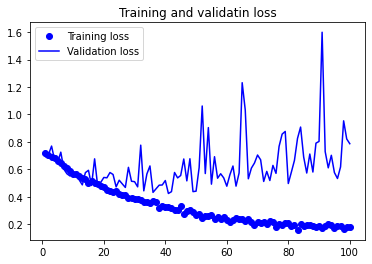

In [40]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validatin loss')
plt.legend()

plt.show()

Test

In [41]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 49ms/step - loss: 0.4747 - accuracy: 0.7950
Test accuracy: 0.795


In [62]:
# load the model we saved
model = load_model('cats_and_dogs_augmentation.h5')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# predicting images
img = image.load_img(os.path.join(test_img_path, "dog/dog.2499.jpg"), target_size=(180, 180))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.array(x)
prediction = model.predict(images, batch_size=32)
print(prediction)

label_map = generator.class_indices
label_map
# the result tend to be a dog and very firm

[[0.9985446]]


{'cat': 0, 'dog': 1}